In [1]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [2]:
# Use fivethirtyeight styling, because I like it
style.use('seaborn-whitegrid')

In [3]:
df = pd.read_csv('backups/backup_df_from_scraping.csv')

In [4]:
df2 = df.copy()

In [5]:
# # Drop NAs for walk_score, income and transit_score columns
df2 = df2.dropna(subset=['walk_score'])
df2 = df2.dropna(subset=['income'])
df2 = df2.dropna(subset=['transit_score'])

In [6]:
# Drop columns we no longer need
df2 = df2.drop((['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'id', 'date', 'bike_score', 'Neighborhood', 'lat', 'long']), axis=1)

In [7]:
df2 = df2.drop('GEOID', axis=1)

In [8]:
# Looking for outliers greater than 3 std's away from mean
df2['price'].mean() + (3 * df2['price'].std())

1577949.0168299316

In [9]:
# Drop outliers in price (230 records). Outliers = over 3 standard deviations greater than mean.
# 3 standard deviations greater than mean: $1,577,949
mask = df2[df2['price'] >=  (df2['price'].mean() + (3 * df2['price'].std()))]
df2.drop(mask.index, inplace=True)

In [10]:
df2.count()

price               14752
bedrooms            14752
bathrooms           14752
sqft_living         14752
sqft_lot            14752
floors              14752
waterfront          14752
view                14752
condition           14752
grade               14752
sqft_above          14752
sqft_basement       14752
yr_built            14752
yr_renovated        14752
zipcode             14752
sqft_living15       14752
sqft_lot15          14752
Address             14752
walk_score          14752
transit_score       14752
pers_crime_score     5855
prop_crime_score     5855
income              14752
dtype: int64

In [11]:
# Cleaning single digit columns from scraped data (it contained an extra backslash)
# Recasting columns as integers rather than float


def remove_chars(x):
	if '/' in x:
		x = x[1]
	return x

df2['walk_score'] = df2['walk_score'].astype('str').apply(remove_chars).astype('int')
df2['transit_score'] = df2['transit_score'].astype('str').apply(remove_chars).astype('int')
df2['income'] = df2['income'].astype('int')


In [12]:
df2.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'Address', 'walk_score', 'transit_score',
       'pers_crime_score', 'prop_crime_score', 'income'],
      dtype='object')

In [13]:
# Drop duplicates. There were 5 duplicates.

df2.drop_duplicates(subset=['price',
       'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'sqft_living15', 'sqft_lot15'], inplace=True)

In [ ]:
pd.to_numeric(df2['walk_score'], errors='coerce')

In [15]:
df2['transit_score'] = df2['transit_score'].astype('str').apply(remove_chars).astype('int')

In [16]:
df3 = df2.copy()

In [17]:
df3 = df3.dropna(subset=['pers_crime_score'])
df3 = df3.dropna(subset=['prop_crime_score'])

In [18]:
# Creating a new column to reflect when the house was actually renovated.
# If house has not been renovated, column will reflect the year it was built.

df3['renovated_2'] = np.where(df3['yr_renovated']==0, df3['yr_built'], df3['yr_renovated'])

In [19]:
# Create new column to reflect the number of years ago it was most recently renovated.
df3['renovated_yrs_ago'] = 2015 - df3['renovated_2']

In [20]:
# Changing letter grades to numerical values


def make_grade_numerical(x):
    if x=='A':
        return 1
    elif x=='B':
        return 2
    elif x=='C':
        return 3
    elif x=='D':
        return 4
    elif x=='E':
        return 5
    else:
        return x
    

df3['prop_crime_score'] = df3['prop_crime_score'].apply(make_grade_numerical)
df3['pers_crime_score'] = df3['pers_crime_score'].apply(make_grade_numerical)

In [21]:
# Same as above, change year built to # of years ago house was built
df3['yr_built'] = 2015 - df['yr_built']

In [ ]:
# Making the crime scores numerical since they were letter grades before
pd.to_numeric(df3['prop_crime_score'], errors='coerce')
pd.to_numeric(df3['pers_crime_score'], errors='coerce')

In [23]:
# Dropping rows we no longer need
df3 = df3.drop('Address', axis=1)
df3 = df3.drop('zipcode', axis=1)
df3 = df3.drop('yr_renovated', axis=1)
df3 = df3.drop('renovated_2', axis=1)

In [24]:
# Creating new variable, log of home price <-- our target/dependent variable
# Did this to give our DV a more normal distribution - see plots below
df3['log_price'] = df3['price'].apply(lambda x: np.log(x))

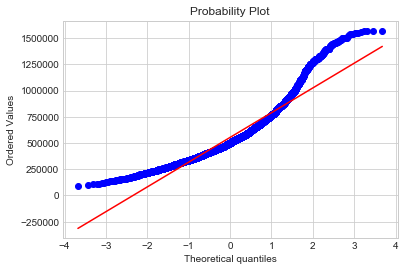

In [25]:
import scipy.stats
scipy.stats.probplot(df3['price'], dist="norm", plot=plt);

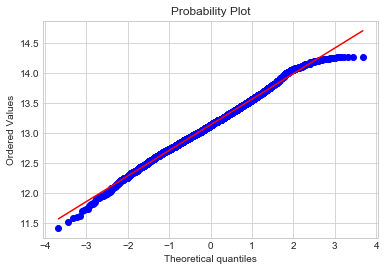

In [26]:
import scipy.stats
scipy.stats.probplot(df3['log_price'], dist="norm", plot=plt);

In [27]:
# Drop rows that don't have a Walk Score grade for personal and property crime
df3['pers_crime_score'].dropna(inplace=True)
df3['prop_crime_score'].dropna(inplace=True)

In [28]:
# Export data so I can use this in the next steps
df3.to_csv('final_data_set.csv')

In [42]:
df3 = pd.read_csv('final_data_set.csv')
df3 = df3.drop('Unnamed: 0', axis=1)

In [43]:
df3.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15',
       'walk_score', 'transit_score', 'pers_crime_score', 'prop_crime_score',
       'income', 'renovated_yrs_ago', 'log_price'],
      dtype='object')

In [31]:
X = df3[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
         'waterfront', 'view', 'condition', 'grade', 'sqft_above',
         'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15',
         'walk_score', 'transit_score', 'pers_crime_score', 'prop_crime_score',
         'income', 'renovated_yrs_ago']]
y = df3['log_price']


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
lm = LinearRegression()

In [34]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
predictions = lm.predict(X_test)

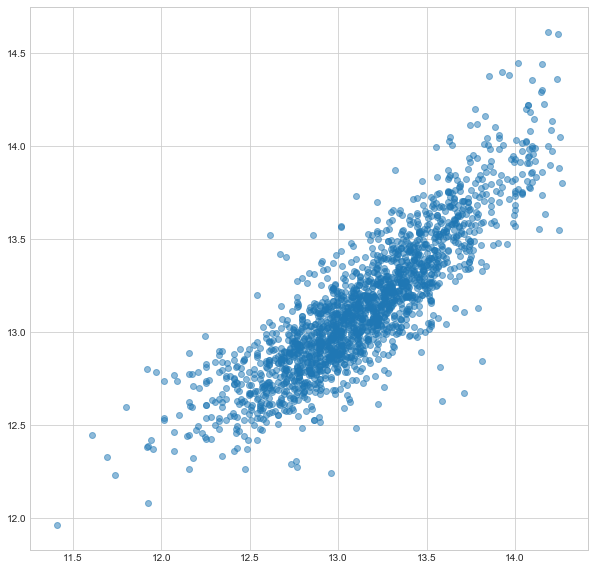

In [36]:
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, alpha=0.5)

In [38]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('log_price ~ + bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + sqft_living15 + sqft_lot15 + walk_score + transit_score + income', data=df3, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     976.0
Date:                Sun, 14 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:33:51   Log-Likelihood:                 497.38
No. Observations:                5852   AIC:                            -960.8
Df Residuals:                    5835   BIC:                            -847.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.3340      0.038    269.215      0.000      10.259      10.409
bedrooms          0.0001      0.004      0.032      0.975      -0.007       0.007
bathrooms         0.0171      0.006      2.730      0.006       0.005       0.029
sqft_living       0.0001   5.03e-06     25.439      0.000       0.000       0.000
sqft_lot       9.031e-07   8.92e-07      1.013      0.311   -8.45e-07    2.65e-06
floors           -0.0095      0.008     -1.249      0.212      -0.024       0.005
waterfront        0.4719      0.069      6.829      0.000       0.336       0.607
view              0.0485      0.004     10.983      0.000       0.040       0.057
condition         0.0554      0.005     12.098      0.000       0.046       0.064
grade             0.1506      0.005     29.868      0.000       0.141       0.160
sqft_above     9.289e-05   6.07e-06     15.306      0.000     8.1e-05       0.000
sqft_basement  3.519e-05   6.34e-06      5.553      0.000    2.28e-05    4.76e-05
yr_built          0.0019      0.000     15.450      0.000       0.002       0.002
sqft_living15     0.0001   8.89e-06     13.062      0.000    9.86e-05       0.000
sqft_lot15    -1.378e-06   8.44e-07     -1.634      0.102   -3.03e-06    2.76e-07
walk_score        0.0048      0.000     23.883      0.000       0.004       0.005
transit_score     0.0018      0.000      5.528      0.000       0.001       0.002
income         4.539e-06    1.3e-07     34.841      0.000    4.28e-06    4.79e-06
==============================================================================
Omnibus:                      285.184   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              535.940
Skew:                          -0.368   Prob(JB):                    4.19e-117
Kurtosis:                       4.287   Cond. No.                     3.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.23e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""